In [41]:
%load_ext Cython
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt  
import scipy.interpolate
from scipy.ndimage.interpolation import rotate
from insert import insert

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [161]:
def low_pass_filter(img):
    n0, n1 = img.shape

    x, y = np.mgrid[0:n0, 0:n1]
    x -= n0//2
    y -= n1//2
    r = np.sqrt(x*x + y*y)

    fil = np.fft.ifftshift(np.where(r < min(n0, n1)/3, 1, 0))

    filtered_img = np.fft.ifft2( np.fft.fft2(img) * fil ).real
    return filtered_img

def slices_gen(img, thetas):
    l_max = np.max(img.shape)
    slices = np.zeros([len(thetas), l_max], dtype = np.float64)
    for i, theta in enumerate(thetas):
        rotated_img = rotate(img, -theta, reshape = False, prefilter = False)
        mid = rotated_img[rotated_img.shape[0]//2, :]
        pad_width = [int(np.floor(l_max - len(mid))/2.), int(np.ceil((l_max - len(mid))/2.))]
        mid = np.pad(mid, pad_width, mode = "constant", constant_values = 0)
        slices[i] = mid
    return slices

def radon(img, thetas):
    l_max = np.max(img.shape)
    sinogram = np.zeros([len(thetas), l_max], dtype = np.float64)
    for i, theta in enumerate(thetas):
        rotated_img = rotate(img, -theta, reshape = False, prefilter = False)
        proj = np.sum(rotated_img, axis = 0)
        pad_width = [int(np.floor(l_max - len(proj))/2.), int(np.ceil((l_max - len(proj))/2.))]
        proj = np.pad(proj, pad_width, mode = "constant", constant_values = 0)
        sinogram[i] = proj
    return sinogram.T

def iradon(sinogram, thetas):
    n0, n1 = sinogram.shape
    assert(n1 == len(thetas))
    thetas = thetas / 180 * np.pi
    fil = np.abs(np.fft.fftfreq(n0)).reshape((-1, 1))
    filtered_sino = np.fft.ifft(np.fft.fft(sinogram, axis = 0) * fil, axis = 0).real

    x, y = np.mgrid[0:n0,0:n0]
    x -= n0//2
    y -= n0//2
    t = np.arange(n0) - n0//2

    recon = np.zeros([n0,n0], dtype = np.float64)
    for i,theta in enumerate(thetas):
        tt = -x*np.sin(theta) + y*np.cos(theta)
        back_proj = np.interp(tt, t, filtered_sino[:, i])
        recon += back_proj
    return recon

def recon_f(sinogram, thetas):
    n0, n1 = sinogram.shape

    x, y = np.mgrid[0:n0, 0:n0]
    x -= n0//2
    y -= n1//2
    r = np.sqrt(x*x + y*y)

    fil = np.fft.ifftshift(np.where(r < n0/3, 1, 0))
    # fil = 1 #np.abs(np.fft.fftfreq(n0)).reshape((-1, 1))
    ft_sino = np.fft.fftshift( np.fft.fft(sinogram, axis = 0), axes = 0 )
    slices_real = np.real(ft_sino).T
    slices_imag = np.imag(ft_sino).T

    model_real = insert(slices_real, thetas)
    model_imag = insert(slices_imag, thetas)

    model = model_real - 1j*model_imag
    # model *= fil

    recon = np.fft.ifft2(np.fft.ifftshift(model)).real

    return model, recon

# def recon_f(sinogram, thetas):
#     n0, n1 = sinogram.shape
#     ff = np.fft.fftfreq(n0)
#     slices = (np.ones((n1,n0))*ff).T
#     slices = np.fft.fftshift(slices, axes=0)
#     model = insert(slices.T, thetas)
#     model = np.fft.ifftshift(model)
#     return model

In [162]:
%%cython
import numpy as np 
cimport numpy as np 
from libc.math cimport sin, cos

def insert(np.ndarray[np.float64_t, ndim = 2] slices, np.ndarray[np.float64_t, ndim = 1] thetas):

    thetas = thetas / 180 * np.pi
    cdef np.ndarray[np.float64_t, ndim = 1] slc
    cdef int s0, s1, sc, c0, c1, x, y
    cdef double xx, yy, fx, fy, ifx, ify, w, th
    cdef Py_ssize_t i, t


    s0 = slices.shape[0]
    s1 = slices.shape[1]
    assert(s0 == len(thetas))
    n0 = s1
    n1 = s1

    sc = s1 // 2
    c0 = n0 // 2
    c1 = n1 // 2

    cdef np.ndarray[np.float64_t, ndim = 2] model = np.zeros((n0, n1), dtype = np.float64)
    cdef np.ndarray[np.float64_t, ndim = 2] weight = 2*np.ones((n0, n1), dtype = np.float64)

    for i, th in enumerate(thetas):
        slc = slices[i]
        for t, v in enumerate(slc):
            x = 0
            y = t - sc

            xx = cos(th)*x - sin(th) * y
            yy = sin(th)*x + cos(th) * y

            xx += c0
            yy += c1

            if xx <= 0 or xx >= n0 - 1: continue
            if yy <= 0 or yy >= n1 - 1: continue

            xxx = <int>xx
            yyy = <int>yy

            fx = xx - xxx
            fy = yy - yyy
            ifx = 1. - fx
            ify = 1. - fy

            d = np.sqrt(fx**2+fy**2)
            if d < weight[xxx, yyy]:
                model[xxx, yyy] = v
                weight[xxx, yyy] = d
           
            d = np.sqrt(fx**2+(1-fy)**2)
            if d < weight[xxx, yyy + 1]:
                model[xxx, yyy + 1] = v
                weight[xxx, yyy + 1] = d

            d = np.sqrt((1-fx)**2+(1-fy)**2)#fx * fy
            if d < weight[xxx + 1, yyy + 1]:
                model[xxx + 1, yyy + 1] = v
                weight[xxx + 1, yyy + 1] = d

            d = np.sqrt((1-fx)**2+fy**2) #fx * ify
            if d < weight[xxx + 1, yyy + 1]:
                model[xxx + 1, yyy] = v
                weight[xxx + 1, yyy] = d

    weight =  np.where(weight == 0., 1., weight)
    return model

In [167]:
### Construct phantom
phantom = np.load("phantom_small.npy")
# X, Y = np.mgrid[-5*np.pi:5*np.pi:64*1j, -5*np.pi:5*np.pi:64*1j]

# y1 = np.sin(X)
# y2 = np.sin(X/np.sqrt(2) + Y/np.sqrt(2))

# phantom = y1 + y2

# phantom = np.pad(phantom, pad_width = [[100,101],[100,101]], mode = "constant", constant_values = 0)
phantom = low_pass_filter(phantom)
thetas = np.arange(0, 180, 1)
thetas = np.asarray(thetas, dtype = np.float64)

In [168]:
sinogram = radon(phantom, thetas)

In [169]:
recon_fbp = iradon(sinogram, thetas)

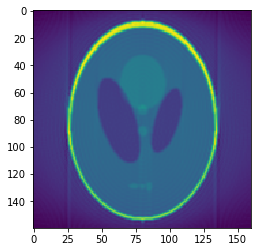

In [170]:
plt.imshow(recon_fbp)

In [171]:
model, recon_insertion = recon_f(sinogram, thetas)

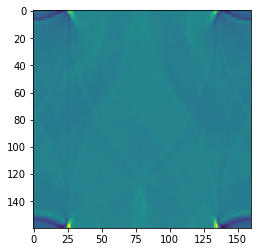

In [172]:
plt.imshow(recon_insertion)

In [87]:
slices = slices_gen(phantom, thetas)

In [88]:
recon_real = insert(slices, thetas)

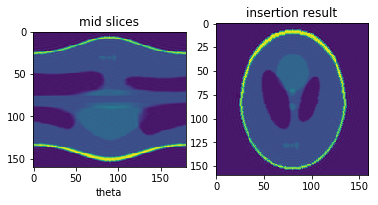

In [89]:
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.imshow(slices.T)
ax1.set_title("mid slices")
ax1.set_xlabel("theta")
ax2.imshow(recon_real)
ax2.set_title("insertion result")

In [ ]:
n0, n1 = 160, 160
x, y = np.mgrid[0:n0, 0:n1]
x -= n0//2
y -= n1//2
r = np.sqrt(x*x + y*y)

fil = np.fft.ifftshift(np.where(r < min(n0, n1)/3, 1, 0))


In [ ]:
plt.imshow(fil)

In [159]:
mm = recon_f(sinogram, thetas)
mm2 = np.fft.fftshift(mm)

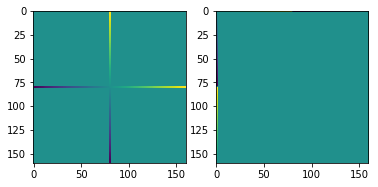

In [160]:
f, (ax1,ax2) = plt.subplots(ncols=2)
ax2.imshow(mm)
ax1.imshow(mm2)

In [153]:
X, Y = np.mgrid[-5*np.pi:5*np.pi:128*1j, -5*np.pi:5*np.pi:128*1j]

# y1 = np.sin(X)
y2 = np.sin(X/np.sqrt(2) + Y/np.sqrt(2))

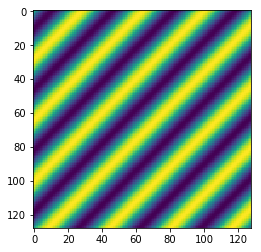

In [154]:
plt.imshow(y2)

In [155]:
s=(np.fft.fft2(y2)).imag

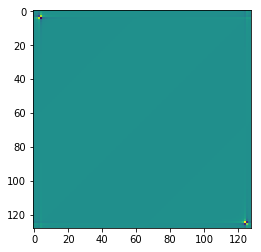

In [156]:
plt.imshow(s)

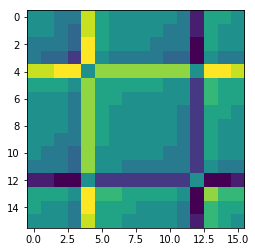

In [152]:
plt.imshow(s.round())